### See if feature decoding is better when feature is the rule
Line of thought: can you decode shape better when shape is the rule?
- Train decoders only on the last 8 correct trials of the block, 
- split train/test up by blocks, ensuring that test set has blocks with each feature dimension being the rule
- split accuracy evaluation by whether feature dimension is rule or not, ex for shape eval:
    - test on blocks where shape is not rule
    - test on block where shape is the rule
- see if there's difference in test performance



In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import scipy.stats
from lfp_tools import (
    general as lfp_general,
    startup as lfp_startup,
    development as lfp_development,
    analysis as lfp_analysis
)
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import s3fs
import utils.behavioral_utils as behavioral_utils
import utils.spike_utils as spike_utils
import utils.classifier_utils as classifier_utils
import utils.visualization_utils as visualization_utils
import utils.io_utils as io_utils
from trial_splitters.random_splitter import RandomSplitter
from trial_splitters.block_splitter import BlockSplitter
from trial_splitters.kfold_splitter import KFoldSplitter
from trial_splitters.feature_block_splitter import FeatureBlockSplitter
from sklearn import svm
from sklearn.linear_model import LogisticRegression, LinearRegression
from models.value_models import ValueNormedModel, ValueNormedDropoutModel
import pickle

from models.multinomial_logistic_regressor import NormedDropoutMultinomialLogisticRegressor
from models.model_wrapper import ModelWrapper, ModelWrapperLinearRegression

from models.trainer import Trainer
from sklearn.cluster import KMeans

import torch
from torch import nn

import plotly.express as px
import matplotlib.patches as patches

import scipy.stats as sci_stats
import scipy

from itertools import accumulate


matplotlib.rcParams['figure.dpi'] = 300
matplotlib.rcParams.update({'font.size': 20})



species = 'nhp'
subject = 'SA'
exp = 'WCST'
session = 20180802  # this is the session for which there are spikes at the moment. 

feature_dims = ["Color", "Shape", "Pattern"]

pre_interval = 1300
post_interval = 1500

In [3]:
# grab behavioral data, spike data, trial numbers. 
fs = s3fs.S3FileSystem()
behavior_file = spike_general.get_behavior_path(subject, session)
behavior_data = pd.read_csv(fs.open(behavior_file))
# only look at corrects for this one
valid_beh = behavior_data[behavior_data.Response.isin(["Correct"])]   
shuffled_card_idxs = behavioral_utils.get_shuffled_card_idxs(valid_beh)
valid_beh = valid_beh[valid_beh.TrialNumber >= 57]

In [12]:
# subselect only last 8 
def label_trials(block_group):
    block_len = len(block_group)
    block_group["TrialUntilRuleChange"] = block_len - block_group["TrialAfterRuleChange"]
    last_eight = block_group[block_group["TrialUntilRuleChange"] <= 8]
    return last_eight
block_groups = valid_beh.groupby(["BlockNumber"], as_index=False)
last_eights = block_groups.apply(label_trials).reset_index()

In [15]:
frs = pd.read_pickle(fs.open("l2l.pqz317.scratch/firing_rates_1300_fb_1500_100_bins.pickle"))
feature_selections = pd.read_pickle(fs.open("l2l.pqz317.scratch/feature_selections.pickle"))

In [16]:
# only look at trial numbers of last eights
frs = frs[frs.TrialNumber.isin(last_eights.TrialNumber)]
feature_selections = feature_selections[feature_selections.TrialNumber.isin(last_eights.TrialNumber)]

In [13]:
# figure out trials where hidden rule is certain feature dimension
rule_color = last_eights[last_eights.CurrentRule.isin(['CYAN', 'GREEN', 'MAGENTA', 'YELLOW'])]
rule_shape = last_eights[last_eights.CurrentRule.isin(['CIRCLE', 'SQUARE', 'STAR', 'TRIANGLE'])]
rule_pattern = last_eights[last_eights.CurrentRule.isin(['ESCHER', 'POLKADOT', 'RIPPLE', 'SWIRL'])]

rule_dims = {"Color": rule_color, "Shape": rule_shape, "Pattern": rule_pattern}

In [ ]:
for feature_dim in feature_dims:
    num_neurons = len(frs.UnitID.unique())
    classes = feature_selections[feature_dim].unique()
    init_params = {"n_inputs": num_neurons, "p_dropout": 0.5, "n_classes": len(classes)}
    trainer = Trainer(learning_rate=0.01)
    wrapped = ModelWrapper(NormedDropoutMultinomialLogisticRegressor, init_params, trainer, classes)

    mode = "SpikeCounts"

    # prep data for classification
    inputs = frs.rename(columns={mode: "Value"})
    labels = feature_selections.rename(columns={feature_dim: "Feature"})

    feature_block_splitter = FeatureBlockSplitter(last_eights)

    outputs = classifier_utils.evaluate_classifiers_by_time_bins(
        wrapped, inputs, labels, np.arange(0, 2.8, 0.1), feature_block_splitter
    )
    io_utils.save_model_outputs(
        fs, 
        f"{feature_dim}_last_eights_normed_dropout", 
        f"{pre_interval}_fb_{post_interval}",
        "feature_block_split",
        outputs
    )

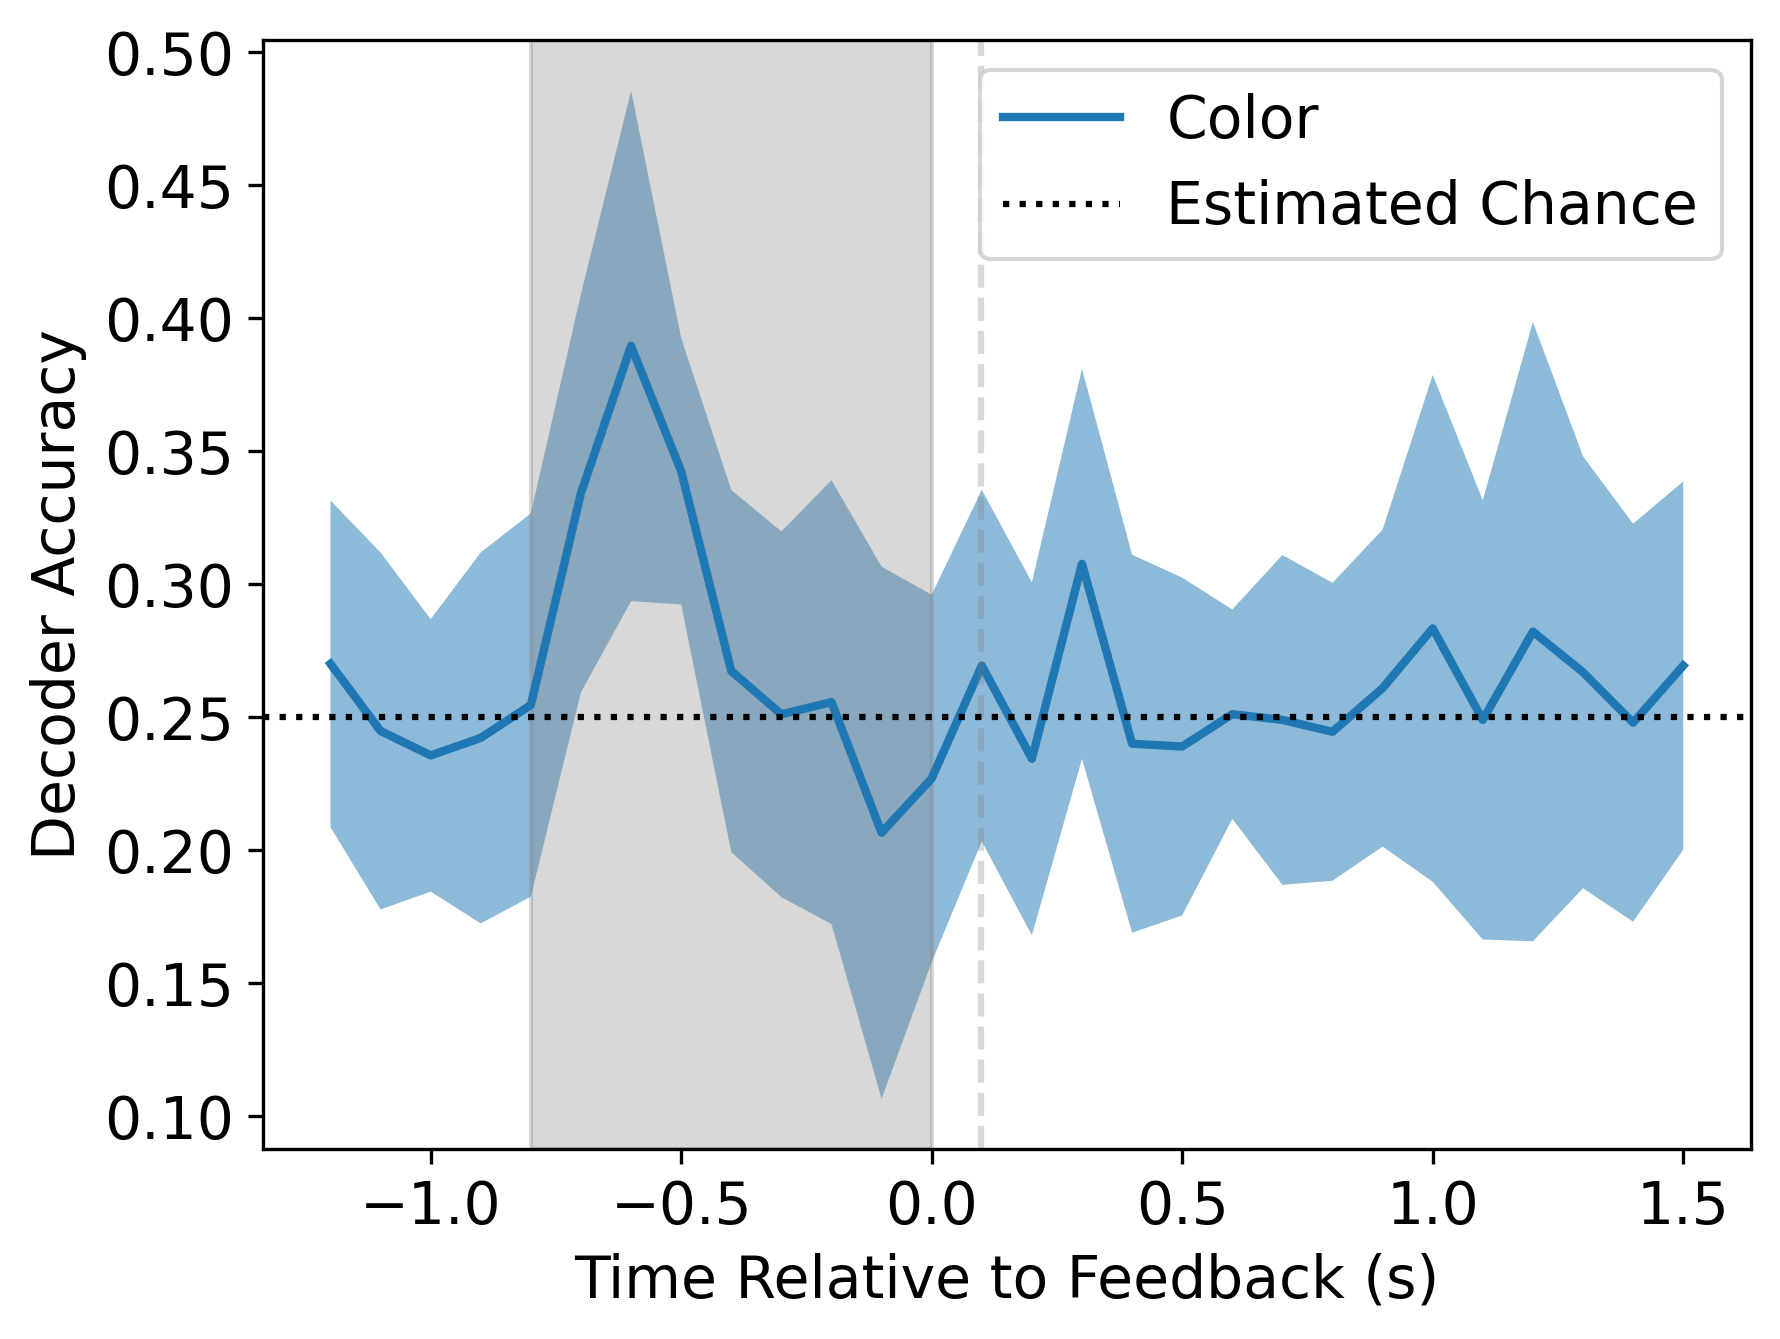

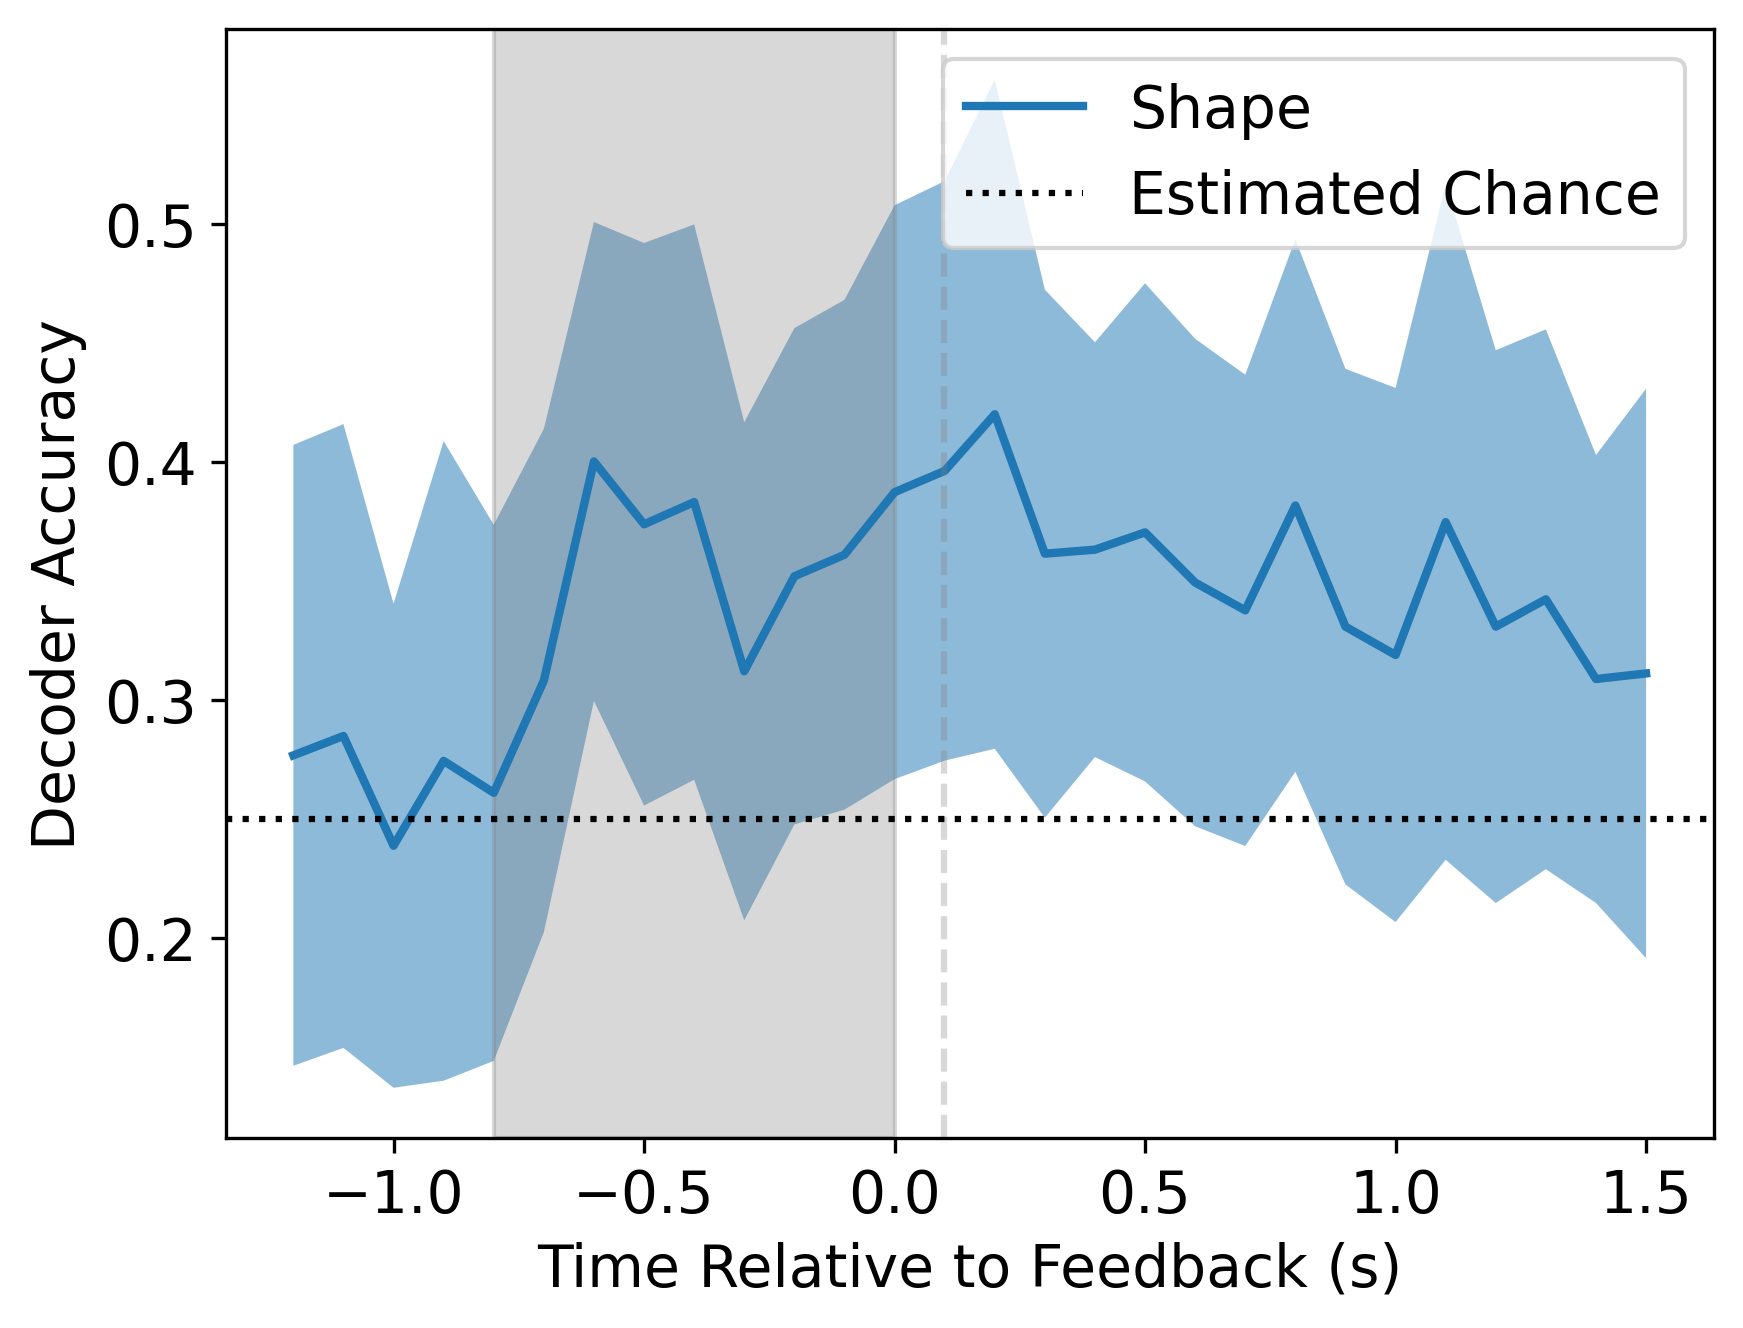

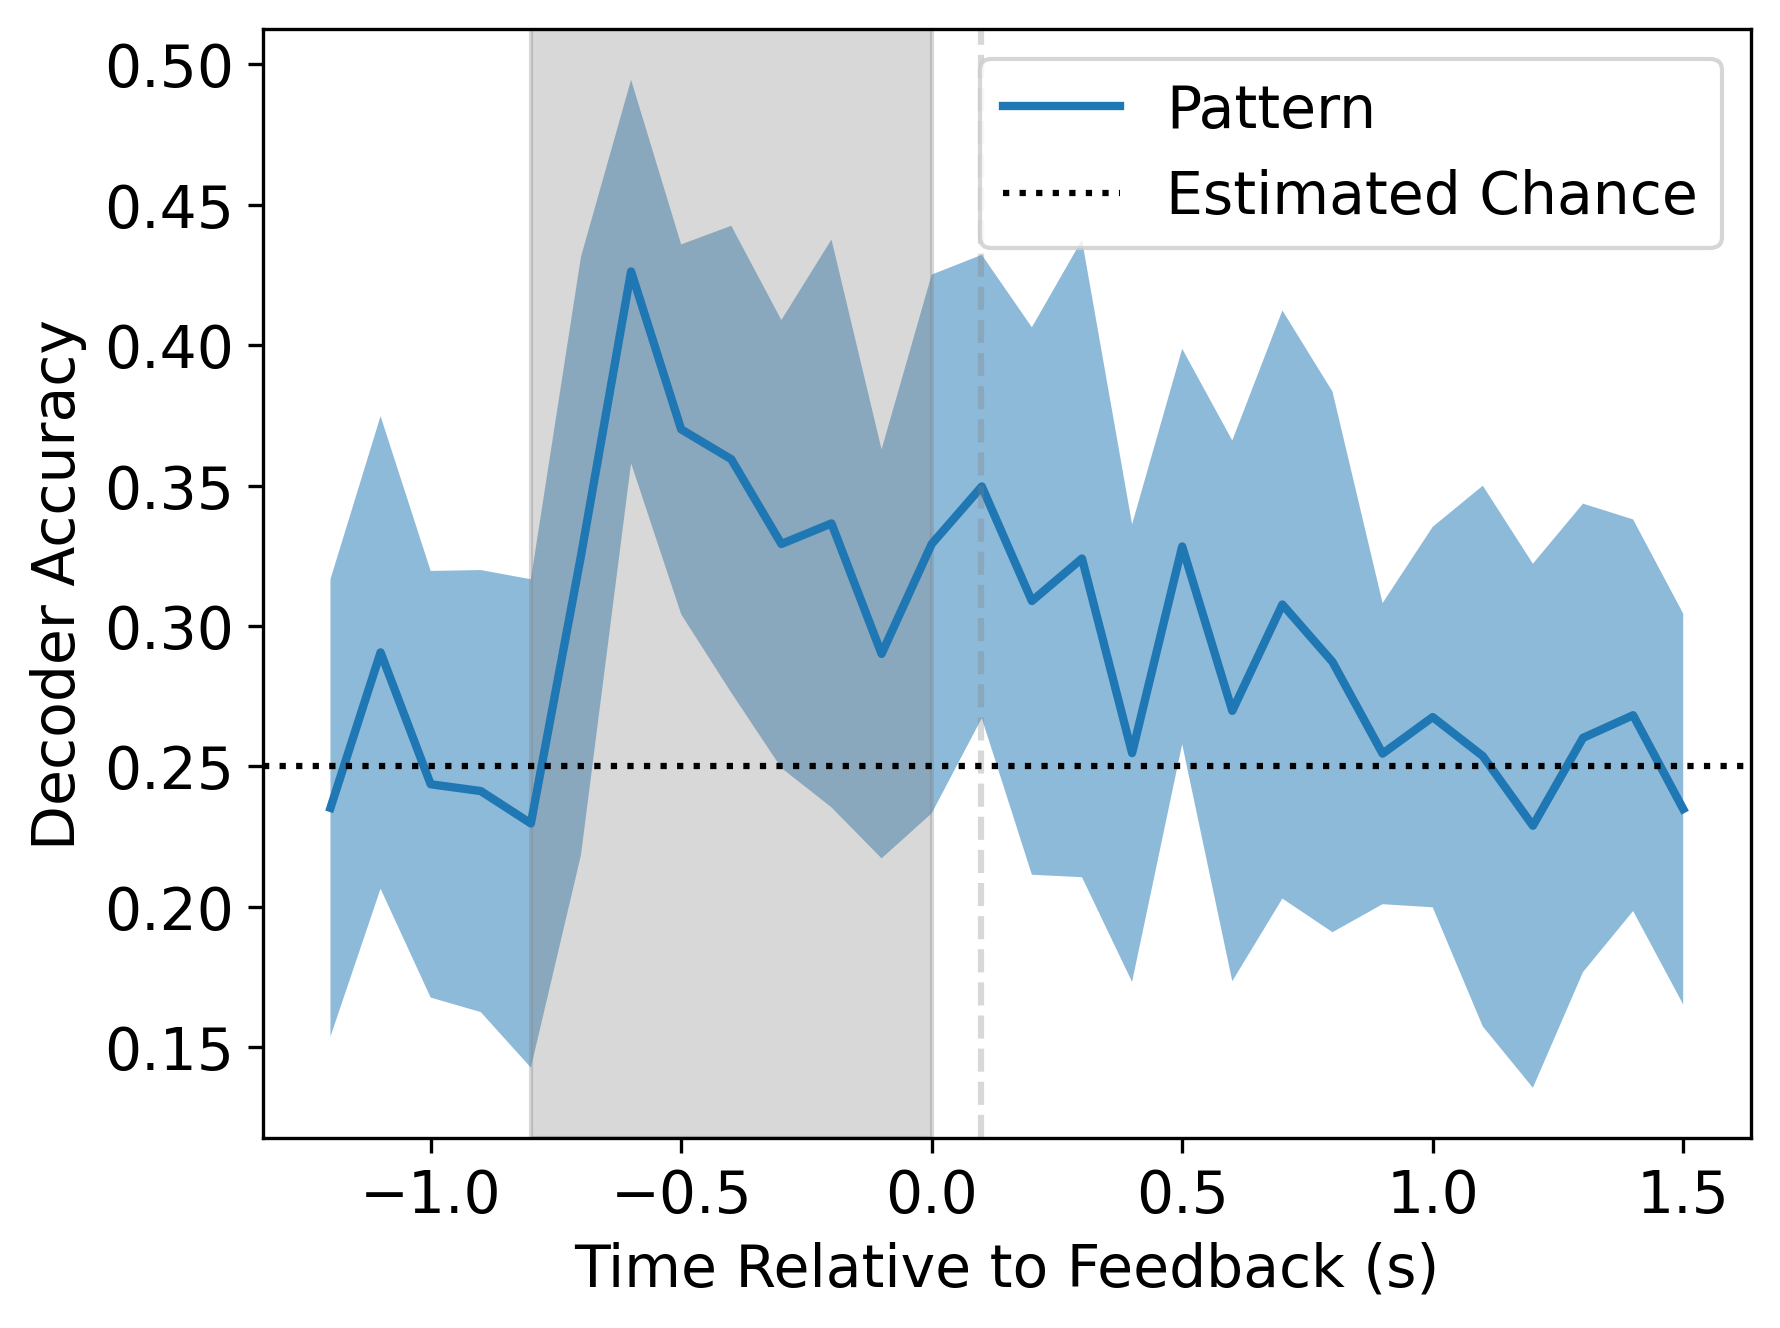

In [23]:
matplotlib.rcParams.update({'font.size': 14})
for i, feature_dim in enumerate(feature_dims):
    fig, ax = plt.subplots()

    _, test_accs_by_bin, _, _, _ = io_utils.load_model_outputs(
        fs, 
        f"{feature_dim}_last_eights_normed_dropout", 
        f"{pre_interval}_fb_{post_interval}",
        "feature_block_split",
    )

    visualization_utils.visualize_accuracy_across_time_bins(
        test_accs_by_bin,
        1.3, 1.5, 0.1,
        ax,
        label=f"{feature_dim}",
        right_align=True, 
        # color='black'
    )

    ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
    ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
    ax.axhline(0.25, color='black', linestyle='dotted', label="Estimated Chance")
    ax.set_xlabel("Time Relative to Feedback (s)")
    ax.set_ylabel("Decoder Accuracy")
    ax.legend(prop={'size': 14})

### Take the models, run them through again but separate blocks

In [19]:
feature_dim = "Color"
_, _, _, models, splits = io_utils.load_model_outputs(
        fs, 
        f"{feature_dim}_last_eights_normed_dropout", 
        f"{pre_interval}_fb_{post_interval}",
        "feature_block_split",
)

In [20]:
models.shape

(28, 13)

In [11]:
len(splits)

13

In [34]:
matplotlib.rcParams.update({'font.size': 14})

mode = "SpikeCounts"
fr_inputs = frs.rename(columns={mode: "Value"})
for feature_dim in feature_dims:
    _, _, _, models, splits = io_utils.load_model_outputs(
            fs, 
            f"{feature_dim}_last_eights_normed_dropout", 
            f"{pre_interval}_fb_{post_interval}",
            "feature_block_split",
    )
    labels = feature_selections.rename(columns={feature_dim: "Feature"})

    time_bins = np.arange(0, 2.8, 0.1)
    in_dim_acc = np.empty(models.shape)
    out_dim_acc = np.empty(models.shape)
    for split_idx, split in enumerate(splits):
        train, test = split
        rule_dim = rule_dims[feature_dim]
        in_dim_trials = rule_dim[rule_dim.TrialNumber.isin(test)].TrialNumber.values
        out_dim_trials = test[~np.isin(test, in_dim_trials)]

        for time_idx, time_bin in enumerate(time_bins):
            fr_inputs_for_bin = fr_inputs[np.isclose(fr_inputs["TimeBins"], time_bin)]
            # print(in_dim_trials)
            x_in = classifier_utils.transform_to_input_data(fr_inputs_for_bin, trials_filter=in_dim_trials)
            y_in = classifier_utils.transform_to_label_data(labels, trials_filter=in_dim_trials)
            x_out = classifier_utils.transform_to_input_data(fr_inputs_for_bin, trials_filter=out_dim_trials)
            y_out = classifier_utils.transform_to_label_data(labels, trials_filter=out_dim_trials)
            # print(x_in.shape)
            in_dim_acc[time_idx, split_idx] = models[time_idx, split_idx].score(x_in, y_in)
            out_dim_acc[time_idx, split_idx] = models[time_idx, split_idx].score(x_out, y_out)

    fig, ax = plt.subplots()
    visualization_utils.visualize_accuracy_across_time_bins(
        in_dim_acc,
        1.3, 1.5, 0.1,
        ax,
        label=f"Rule is {feature_dim}",
        right_align=True, 
        # color='black'
    )
    visualization_utils.visualize_accuracy_across_time_bins(
        out_dim_acc,
        1.3, 1.5, 0.1,
        ax,
        label=f"Rule is Other",
        right_align=True, 
        # color='black'
    )
    ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
    ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
    ax.axhline(0.25, color='black', linestyle='dotted', label="Estimated Chance")
    ax.set_xlabel("Time Relative to Feedback (s)")
    ax.set_ylabel(f"{feature_dim} Decoder Accuracy")
    ax.legend(prop={'size': 14})


/usr/local/lib/python3.8/dist-packages/numpy/lib/nanfunctions.py:1745: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr, where=where)
/usr/local/lib/python3.8/dist-packages/numpy/lib/nanfunctions.py:1745: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr, where=where)
/usr/local/lib/python3.8/dist-packages/numpy/lib/nanfunctions.py:1745: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr, where=where)
/usr/local/lib/python3.8/dist-packages/numpy/lib/nanfunctions.py:1745: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr, where=where)
/usr/local/lib/python3.8/dist-packages/numpy/lib/nanfunctions.py:1745: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr, where=where)
/usr/local/lib/python3.8/dist-packages/numpy/lib/nanfunctions.py:1745: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(

KeyboardInterrupt: 